<a href="https://colab.research.google.com/github/capybabruh/CustomerSegmentation/blob/main/CustomerPurchaseBehavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Cài đặt thư viện Python

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import figure_factory as FF
from plotly.offline import iplot

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import preprocessing,cluster

from scipy.stats import kurtosis,skew,pearsonr
from scipy.cluster.hierarchy import linkage, dendrogram

from yellowbrick.cluster import KElbowVisualizer

from collections import Counter

from warnings import simplefilter
simplefilter("ignore")


*Scikit-learn là gì?*

Scikit-learn (Sklearn) là thư viện mạnh mẽ nhất dành cho các thuật toán học máy được viết trên ngôn ngữ Python. Thư viện cung cấp một tập các công cụ xử lý các bài toán machine learning và statistical modeling gồm: classification, regression, clustering, và dimensionality reduction.

###Đọc dữ liệu


In [ ]:
file_path = "/content/sample_data/Customer-Purchasing-Behaviors.csv"
data=pd.read_csv(file_path)
print(data.head())

   user_id  age  annual_income  purchase_amount  loyalty_score region  \
0        1   25          45000              200            4.5  North   
1        2   34          55000              350            7.0  South   
2        3   45          65000              500            8.0   West   
3        4   22          30000              150            3.0   East   
4        5   29          47000              220            4.8  North   

   purchase_frequency  
0                  12  
1                  18  
2                  22  
3                  10  
4                  13  


In [ ]:
print(f'There are {data.isnull().sum().sum()} null values in the dataset.')


There are 0 null values in the dataset.


In [ ]:
print(f'There are {data.duplicated().sum()} duplicate rows in the dataset.')


There are 0 duplicate rows in the dataset.


In [ ]:
print(f'The dataset has {data.shape[1]} columns and {data.shape[0]} rows.')


The dataset has 7 columns and 238 rows.


In [ ]:
data.dtypes


,0
user_id,int64
age,int64
annual_income,int64
purchase_amount,int64
loyalty_score,float64
region,object
purchase_frequency,int64


###Basic statics

Bước quan trọng trong việc tìm xem có giá trị ngoại lệ hoặc bất thường nào trong data.

In [ ]:
data.describe()

,user_id,age,annual_income,purchase_amount,loyalty_score,purchase_frequency
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,119.500000,38.676471,57407.563025,425.630252,6.794118,19.798319
std,68.848868,9.351118,11403.875717,140.052062,1.899047,4.562884
min,1.000000,22.000000,30000.000000,150.000000,3.000000,10.000000
25%,60.250000,31.000000,50000.000000,320.000000,5.500000,17.000000
50%,119.500000,39.000000,59000.000000,440.000000,7.000000,20.000000
75%,178.750000,46.750000,66750.000000,527.500000,8.275000,23.000000
max,238.000000,55.000000,75000.000000,640.000000,9.500000,28.000000


###Phân tích bảng dữ liệu:

Khách hàng có tuổi cao nhất là 55 tuổi, thấp nhất là 22 tuổi

Thu nhập hàng năm của khách hàng cao nhất là 75.000$

Thu nhập hàng năm của khách hàng thấp nhất là 30.000$

Khách hàng mua ít nhất 150 món, nhiều nhất là 640 món hàng

Điểm khách hàng cao nhất là 9.5, thấp nhất là 3.0

Số lần mua hàng nhiều nhất trong năm của 1 khách hàng cao nhất là 28 lần, thấp nhất là 10 lần








###Outliers

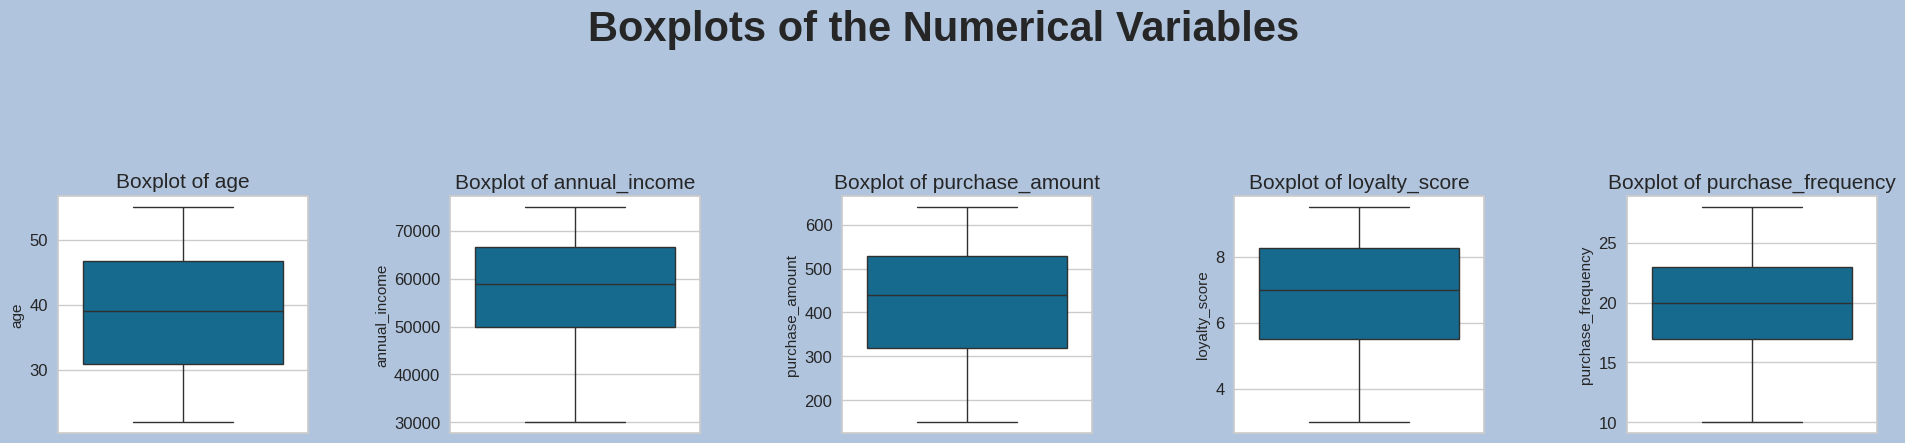

In [ ]:
features = ['age','annual_income','purchase_amount','loyalty_score','purchase_frequency']

fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(ncols=5,figsize=(20,5))  # Increased figsize width

for ax, feature in zip([ax1, ax2, ax3, ax4, ax5], features):
    sns.boxplot(data[feature], ax=ax)
    ax.set_title('Boxplot of ' + str(feature), fontsize=15, fontweight='normal')

fig.suptitle("Boxplots of the Numerical Variables", fontsize=30, fontweight='bold')

# Adjust tight_layout for better spacing
plt.tight_layout(pad=4.0)  # Increased padding

fig.set_facecolor('lightsteelblue')

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.show()

In [ ]:
#Tao danh sach luu % gia tri outlier tung cot
outliers_perc = []

for k,v in data[features].items():
    if data[k].dtype != 'O':
        q1 = v.quantile(0.25) #tu phan vi thu 1
        q3 = v.quantile(0.75) #tu phan vi thu 3
        irq = q3 - q1 #khoang cach giua tu phan vi thu 1 va thu 3
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)] # xac dinh gia tri ngoai lai
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        out_tuple = (k,int(perc))
        outliers_perc.append(out_tuple)
        print("Column %s outliers = %.2f%%" % (k,perc))

Column age outliers = 0.00%
Column annual_income outliers = 0.00%
Column purchase_amount outliers = 0.00%
Column loyalty_score outliers = 0.00%
Column purchase_frequency outliers = 0.00%


###Nhận xét:

Dữ liệu tương đối "sạch": Các giá trị trong các cột này  trong phạm vi dự kiến và không có các điểm dữ liệu bất thường hoặc cực đoan.

Phân bố dữ liệu đồng đều: Dữ liệu có xu hướng tập trung xung quanh giá trị trung bình và không có các giá trị nằm quá xa so với phần lớn dữ liệu khác.

Ít nhiễu: Việc không có giá trị ngoại lai cho thấy dữ liệu có ít nhiễu và có thể đáng tin cậy hơn cho việc phân tích và xây dựng mô hình.

###Phân tích dữ liệu

Bước tính toán độ lệch(Skewness) và độ nhọn(kurtosis) của các phân phối số học

In [ ]:
num_features = ['age','annual_income','purchase_amount','loyalty_score','purchase_frequency']

for col in num_features:
    print(f"Skewness of {col}: {skew(data[col])}")
    print(f"Kurtosis of {col}: {kurtosis(data[col])}")
    print()

Skewness of age: 0.06636274888842215
Kurtosis of age: -1.1925345179354705

Skewness of annual_income: -0.49101253383721116
Kurtosis of annual_income: -0.39077578630221765

Skewness of purchase_amount: -0.24104278982104727
Kurtosis of purchase_amount: -1.005917891933048

Skewness of loyalty_score: -0.3430897907939722
Kurtosis of loyalty_score: -1.0844022070100232

Skewness of purchase_frequency: -0.2355671851575315
Kurtosis of purchase_frequency: -0.7743427362627977



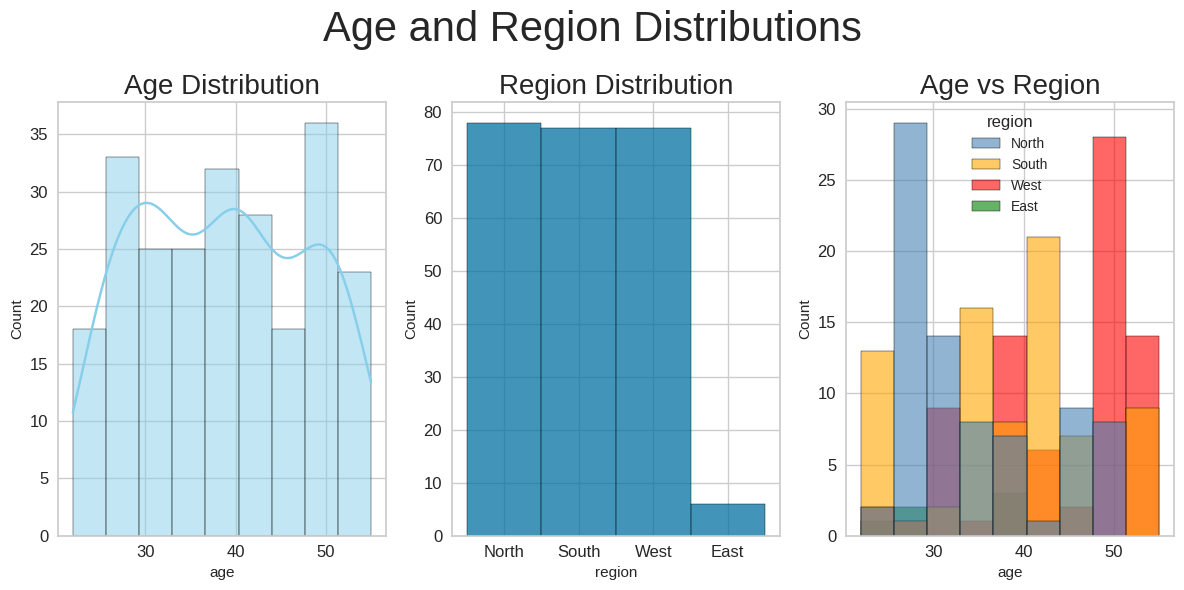

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 6))

ax1 = sns.histplot(data=data, x='age', ax=ax1, color='skyblue', kde=True)
ax1.set_title('Age Distribution', size=20)

ax2 = sns.histplot(data=data, x='region', ax=ax2, palette='Set2')
ax2.set_title('Region Distribution', size=20)

ax3 = sns.histplot(data=data, x='age', hue='region', palette=['steelblue', 'orange', 'red', 'green'], alpha=0.6, ax=ax3)
ax3.set_title('Age vs Region', size=20)

plt.suptitle('Age and Region Distributions', size=30)

plt.tight_layout()
plt.show()


In [ ]:
# Tính tỷ lệ giữa các độ tuổi theo %
age_counts = data['age'].value_counts()
age_percentages = (age_counts / len(data)) * 100

print("Tỷ lệ giữa các độ tuổi:")
print(age_percentages)

Tỷ lệ giữa các độ tuổi:
age
33    5.882353
24    5.882353
41    5.882353
50    5.882353
29    3.781513
31    3.781513
37    3.361345
52    3.361345
26    3.361345
46    3.361345
40    3.361345
39    3.361345
49    3.361345
30    3.361345
38    3.361345
28    3.361345
27    3.361345
36    3.361345
45    3.361345
32    3.361345
43    2.941176
55    2.941176
48    2.941176
51    2.941176
54    2.941176
42    2.941176
34    0.840336
25    0.840336
47    0.420168
35    0.420168
44    0.420168
23    0.420168
22    0.420168
53    0.420168
Name: count, dtype: float64


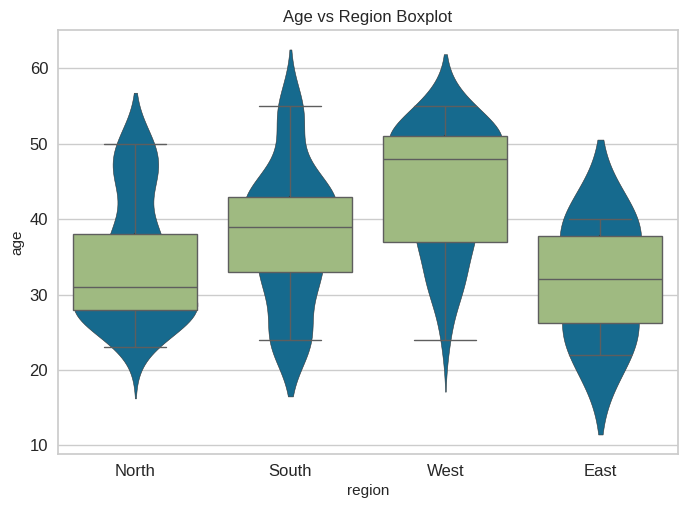

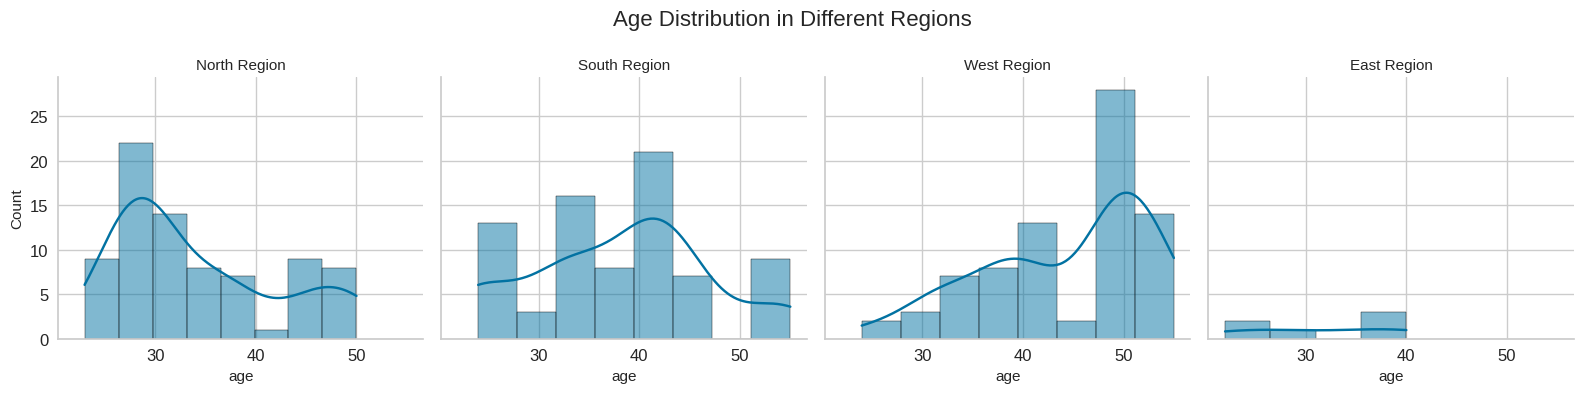

In [ ]:
# Violin plot để xem sự phân bố của Age theo Region
sns.violinplot(x='region', y='age', data=data)
plt.title('Age Distribution by Region')

# Box plot để xem các ngoại lệ trong Age
sns.boxplot(x='region', y='age', data=data)
plt.title('Age vs Region Boxplot')

# Histogram cho mỗi khu vực bằng FacetGrid
g = sns.FacetGrid(data, col='region', col_wrap=4, height=4)
g.map(sns.histplot, 'age', kde=True)
g.set_titles("{col_name} Region")
plt.suptitle('Age Distribution in Different Regions', size=16)
plt.tight_layout()


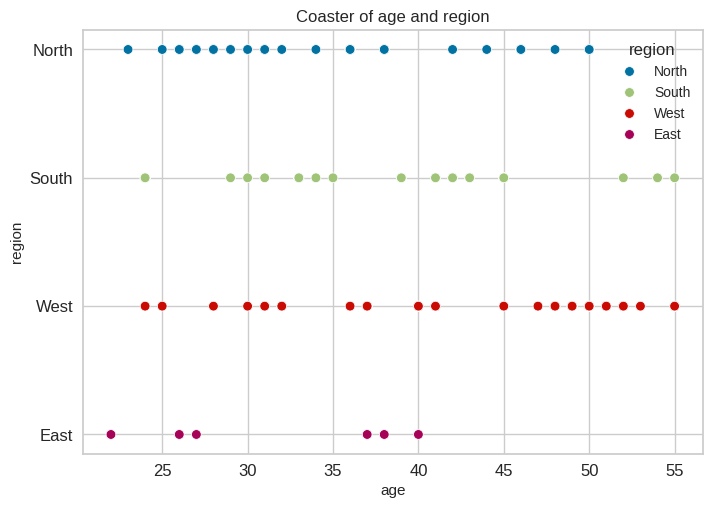

In [ ]:
#Biểu đồ phân tán
sns.scatterplot(x='age', y='region',hue='region', data=data)
plt.title('Coaster of age and region')
plt.show()

Theo biểu đồ cho ta thấy lượng khách hàng ở khu vựa phía Đông là ít nhất ở mọi độ tuổi. Ở khu vực phía Bắc và Tây chiếm phần lớn lượng khách hàng

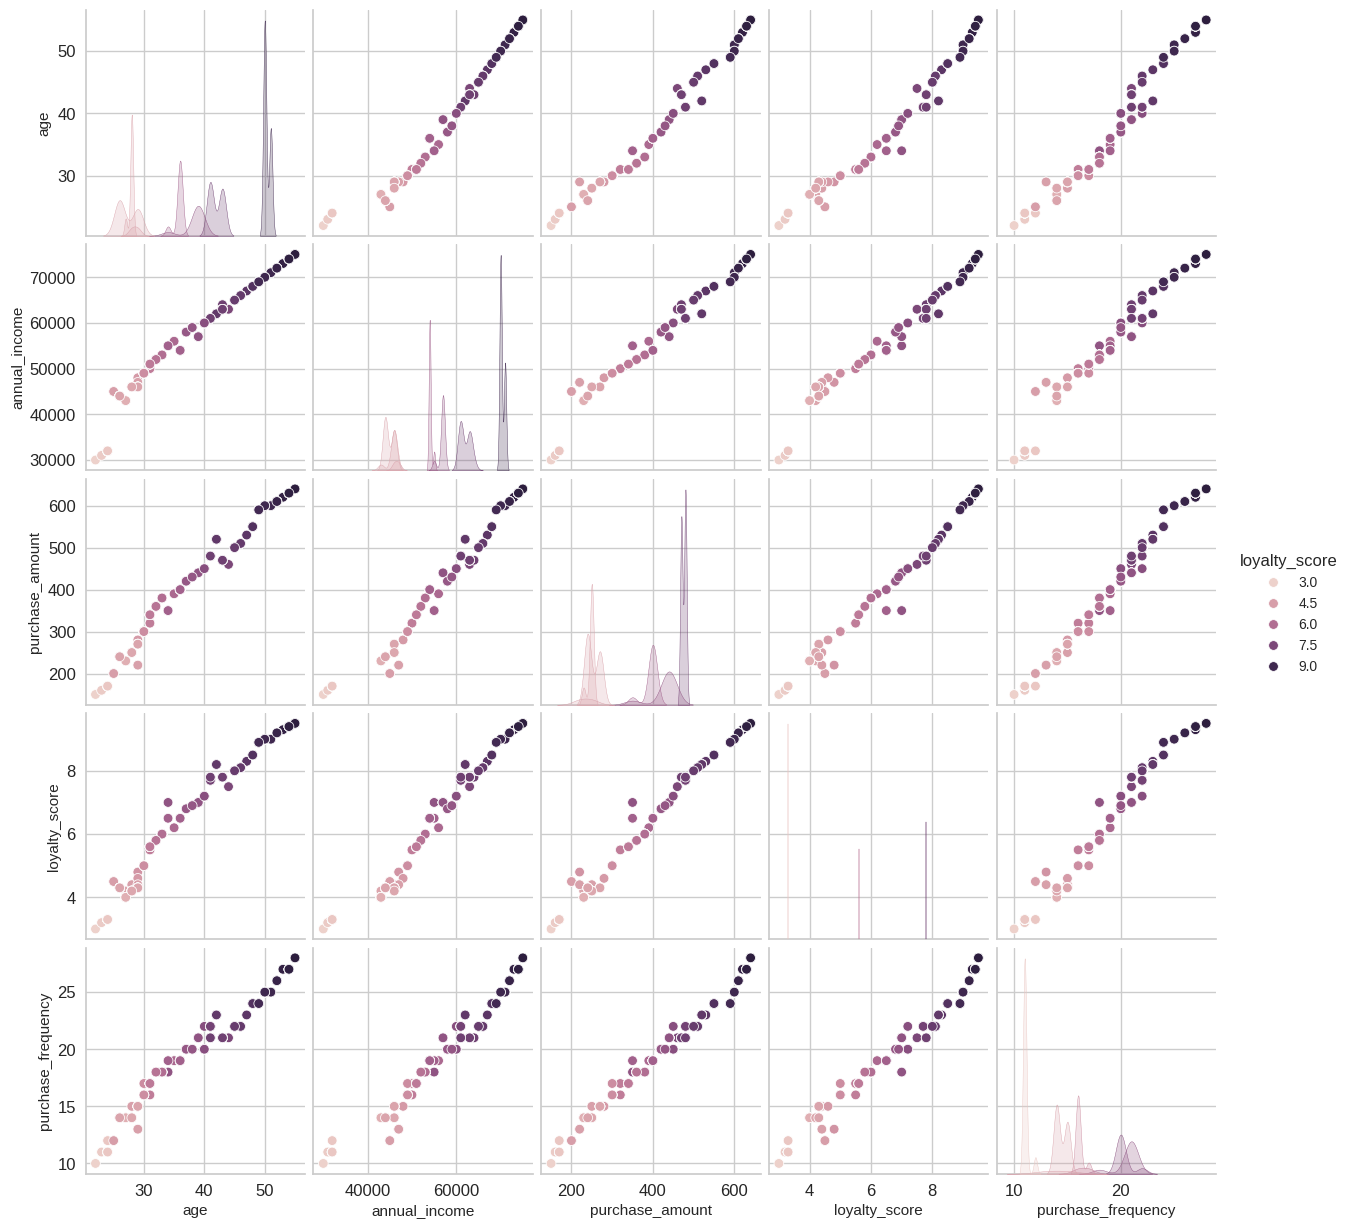

In [ ]:
sns.pairplot(data,
             vars= ['age','annual_income','purchase_amount','loyalty_score','purchase_frequency'],
             hue='loyalty_score')
plt.show()

####Hàm Pairplot trong thư viện Seaborn

Hàm Pairplot trong thư viện Seaborn của Python được sử dụng để trực quan hóa mối quan hệ giữa các cặp biến số trong một tập dữ liệu, gồm các biểu đồ đường chéo chính(histogram hoặc KDE plot) và các biểu đồ ngoài đường chéo chính(scatterplot)

Dựa theo biểu đồ sử dụng Pairplot ta có thể thấy:

*   Điểm thành viên từ 6.0-9.0 tập trung hầu hết ở độ tuổi >40

*   Độ tuổi ít mua sắm nhất ở khoảng dưới 30 tuổi
*   Những khách hàng có mức thu nhập cao sẽ thường xuyên mua sắm






In [ ]:
df_coff= data[['age','annual_income','purchase_amount','loyalty_score','purchase_frequency']].dropna().corr()

<Axes: >

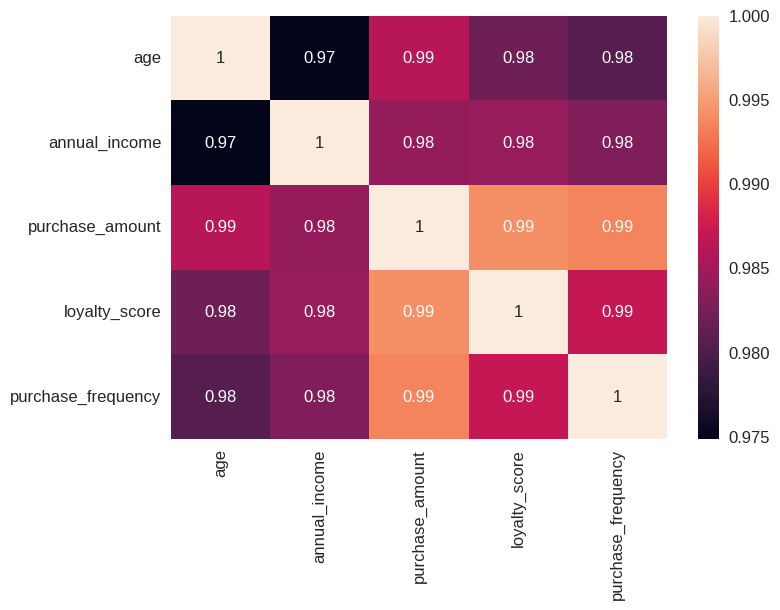

In [ ]:
#Biểu đồ heatmap thể hiện mật độ dữ liệu của các điểm khác nhau
sns.heatmap(df_coff,annot=True)

##Mối tương quan mạnh nhất là giữa các biến:
purchase_amount (số tiền mua hàng) và loyalty_score (điểm trung thành): Điều này khá dễ hiểu, khách hàng mua sắm nhiều thường là khách hàng trung thành.

purchase_amount (số tiền mua hàng) và annual_income (thu nhập hàng năm): Khách hàng có thu nhập cao thường chi tiêu nhiều hơn.

##Mối tương quan yếu nhất (nhưng vẫn rất mạnh):
age (tuổi) và purchase_frequency (tần suất mua hàng):
Mối quan hệ này cho thấy tuổi tác có ảnh hưởng đến tần suất mua hàng, nhưng không mạnh bằng các mối quan hệ khác.

#KMeans Clustering


Trong thuật toán K-means clustering, chúng ta không biết nhãn (label) của từng điểm dữ liệu. Mục đích là làm thể nào để phân dữ liệu thành các cụm (cluster) khác nhau sao cho dữ liệu trong cùng một cụm có tính chất giống nhau.

###Chuẩn bị data

In [ ]:
data.head()

,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,1,25,45000,200,4.5,North,12
1,2,34,55000,350,7.0,South,18
2,3,45,65000,500,8.0,West,22
3,4,22,30000,150,3.0,East,10
4,5,29,47000,220,4.8,North,13


cột user_id không cần thiết nên mình sẽ bỏ nó

In [ ]:
data2=data.drop(['user_id'],axis=1)
data2.head()

,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,25,45000,200,4.5,North,12
1,34,55000,350,7.0,South,18
2,45,65000,500,8.0,West,22
3,22,30000,150,3.0,East,10
4,29,47000,220,4.8,North,13


Mã hóa cột 'region' để xử lý số liệu

In [ ]:
encoder = LabelEncoder()

data2['region'] = encoder.fit_transform(data2['region'])

data2.head()

,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,25,45000,200,4.5,1,12
1,34,55000,350,7.0,2,18
2,45,65000,500,8.0,3,22
3,22,30000,150,3.0,0,10
4,29,47000,220,4.8,1,13


Chú thích: North = 2, South = 0,West = 1, East=3,

Bây giờ sẽ bắt đầu modeling:

###Số cụm tối ưu để phân tích dữ liệu:

Tìm số cụm tối ưu bằng phương pháp 'Elbow method':

Phương pháp Elbow là một cách giúp ta lựa chọn được số lượng các cụm phù hợp dựa vào đồ thị trực quan hoá bằng cách nhìn vào sự suy giảm của hàm biến dạng và lựa chọn ra điểm khuỷ tay (elbow point).

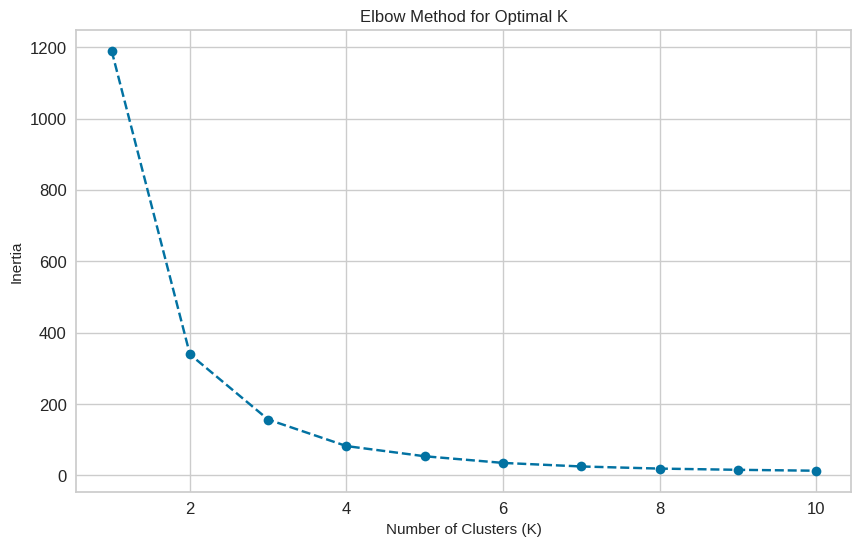

Số cụm (K) tốt nhất để chia dữ liệu là: 3

Số cụm:
cluster
0    95
2    83
1    60
Name: count, dtype: int64


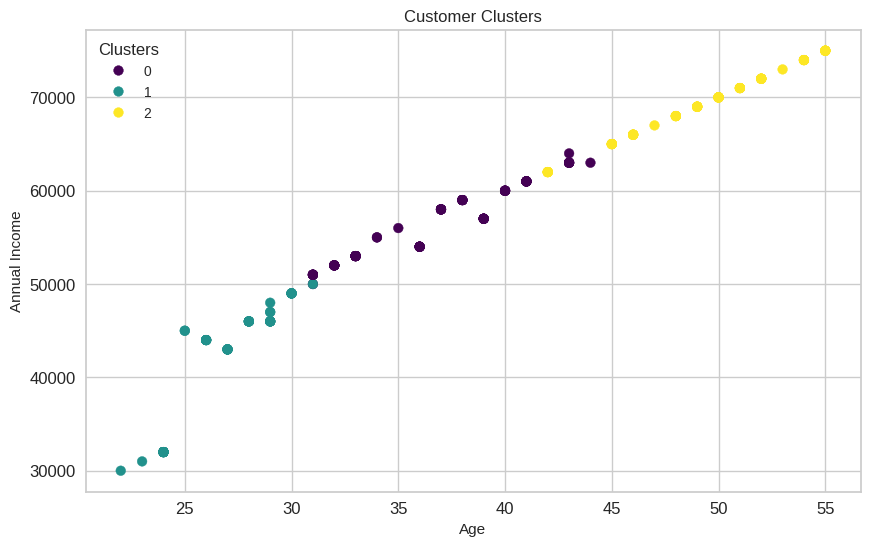

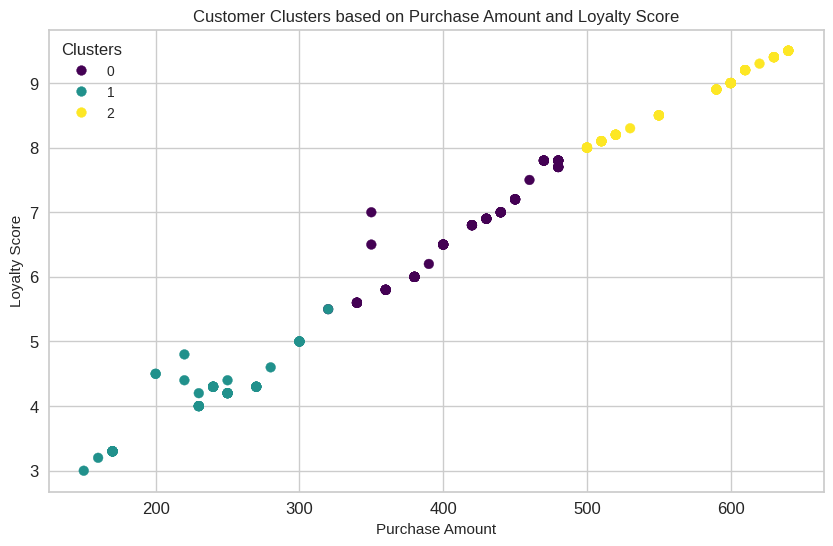

In [ ]:
# Select features for clustering
features = ['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'purchase_frequency']
X = data[features]
#Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Determine the optimal number of clusters using the Elbow method
inertia = []
for i in range(1, 11):
#Train with n_cluster = i , choose centroid with k-means++ algo
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
# Plot the Elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Find the "elbow" point
def find_elbow(inertia):
    diffs = np.diff(inertia)
    diff_ratios = [diffs[i] / diffs[i-1] if i > 0 else 0 for i in range(len(diffs))]
    elbow_index = diff_ratios.index(min(diff_ratios[1:])) + 2
    return elbow_index
optimal_k = find_elbow(inertia)
print(f"Số cụm (K) tốt nhất để chia dữ liệu là: {optimal_k}")
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=0)
data['cluster'] = kmeans_final.fit_predict(X_scaled)
print("\nSố cụm:")
print(data['cluster'].value_counts())
#Visualize clusters based on annual_income and age
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['age'], data['annual_income'], c=data['cluster'], cmap='viridis')
plt.title('Customer Clusters')
plt.xlabel('Age')
plt.ylabel('Annual Income')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

# Visualize clusters based on purchase_amount and loyalty score
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['purchase_amount'], data['loyalty_score'], c=data['cluster'], cmap='viridis')
plt.title('Customer Clusters based on Purchase Amount and Loyalty Score')
plt.xlabel('Purchase Amount')
plt.ylabel('Loyalty Score')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

Sử dụng phương pháp Silhouette_scores và Davies_bouldin_scores:

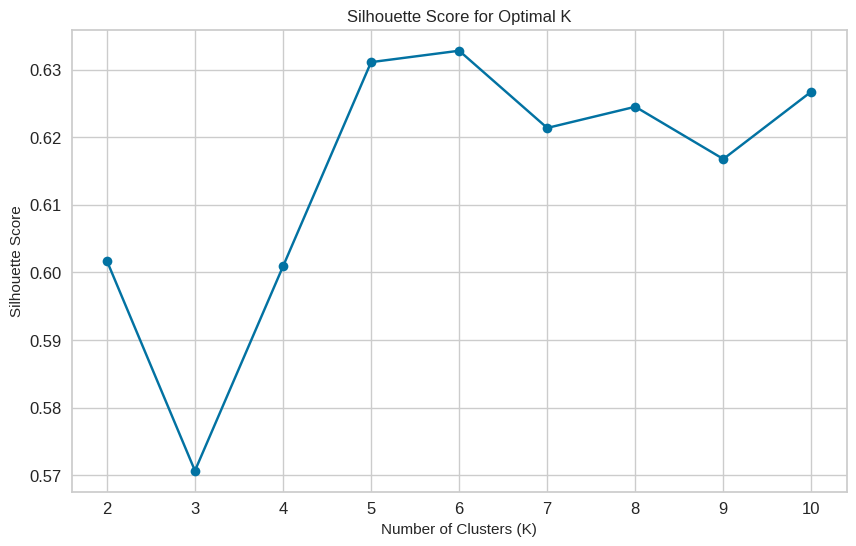

Optimal number of clusters based on Silhouette Score: 6


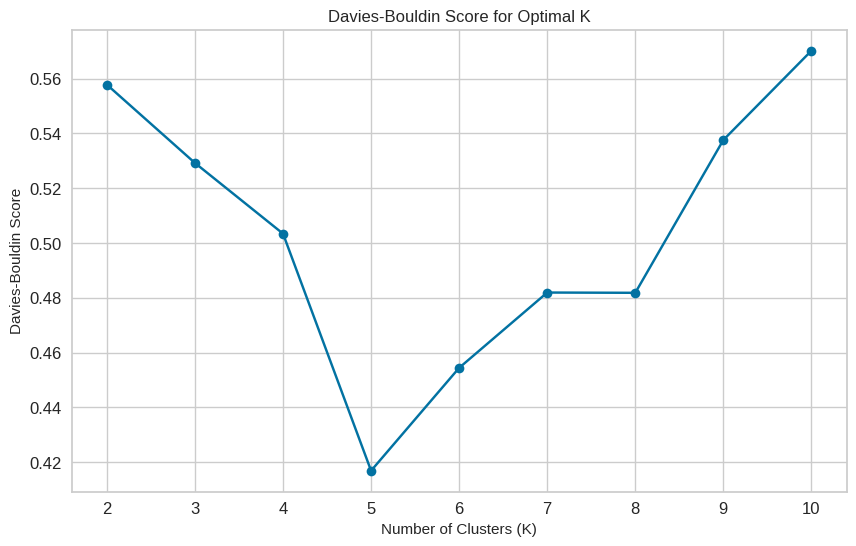

Optimal number of clusters based on Davies-Bouldin Score: 5


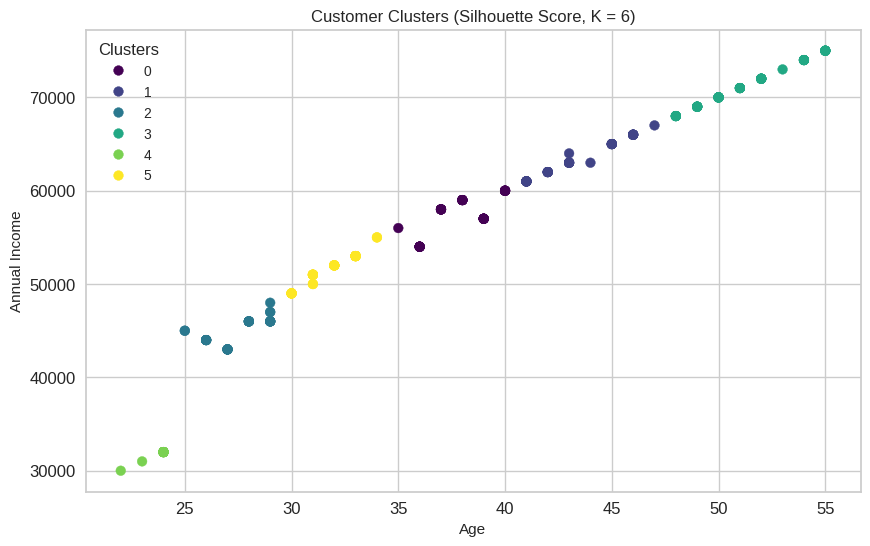

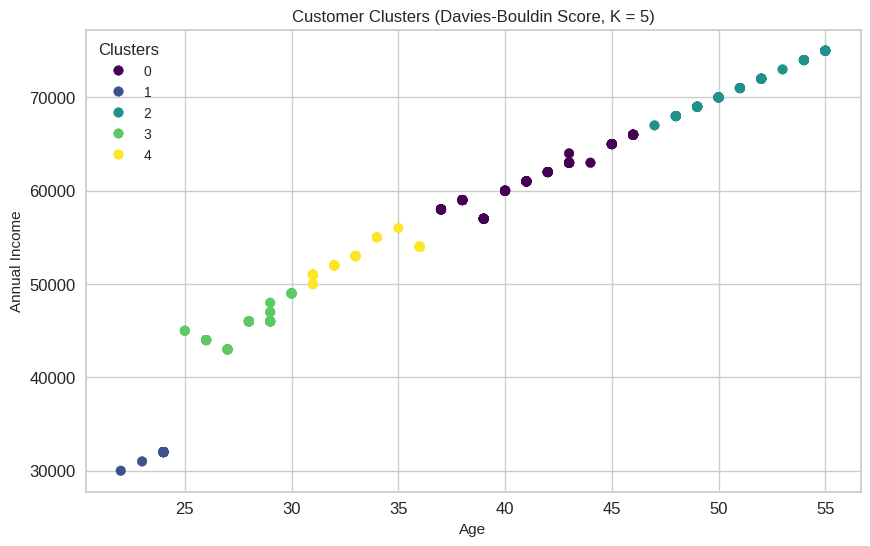

In [ ]:
# Select features for clustering
features = ['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'purchase_frequency']
X = data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize lists to store scores
#Silhouette [-1,1]
silhouette_scores = []
#Bouldin [0,+Inf]
davies_bouldin_scores = []

# Range of clusters to test
cluster_range = range(2, 11)

# Calculate scores for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)
    # Calculate silhouette score
    #The distance between each point of cluster a(i) and from it to another centroid b(i)/max{b(i),a(i)}
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    # Calculate Davies-Bouldin score
    #The avg distance between each point of cluster i and the centroid/distance between 2 centroids
    db_score = davies_bouldin_score(X_scaled, cluster_labels)
    davies_bouldin_scores.append(db_score)
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()
# Find optimal K based on silhouette score
optimal_k_silhouette = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_silhouette}")
# Plot the Davies-Bouldin scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, davies_bouldin_scores, marker='o', linestyle='-')
plt.title('Davies-Bouldin Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)
plt.show()


# Find optimal K based on Davies-Bouldin score
optimal_k_db = cluster_range[np.argmin(davies_bouldin_scores)]
print(f"Optimal number of clusters based on Davies-Bouldin Score: {optimal_k_db}")


# Apply KMeans with the silhouette optimal K
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, init='k-means++', max_iter=300, n_init=10, random_state=0)
data['cluster_silhouette'] = kmeans_silhouette.fit_predict(X_scaled)

# Apply KMeans with the Davies-Bouldin optimal K
kmeans_db = KMeans(n_clusters=optimal_k_db, init='k-means++', max_iter=300, n_init=10, random_state=0)
data['cluster_db'] = kmeans_db.fit_predict(X_scaled)


# Visualize the clusters (example: using age and annual_income) based on silhouette score
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['age'], data['annual_income'], c=data['cluster_silhouette'], cmap='viridis')
plt.title(f'Customer Clusters (Silhouette Score, K = {optimal_k_silhouette})')
plt.xlabel('Age')
plt.ylabel('Annual Income')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()


# Visualize the clusters based on Davies-Bouldin Score
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['age'], data['annual_income'], c=data['cluster_db'], cmap='viridis')
plt.title(f'Customer Clusters (Davies-Bouldin Score, K = {optimal_k_db})')
plt.xlabel('Age')
plt.ylabel('Annual Income')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

Lựa chọn trong thực tế

Silhouette Score: Tốt hơn khi cần đánh giá trực quan sự phân cụm.

Davies-Bouldin Score: Hữu ích trong các bài toán cần so sánh nhiều cấu hình phân cụm.

In [ ]:
def plot_clusters(k, data, labels):
    """
    Plots and visualizes the results of K-Means clustering.

    Args:
        k (int): The number of clusters.
        data (pd.DataFrame): The input DataFrame.
        labels (list): List of column names to be used for clustering.
    """

    # 1. Scale Data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[labels])
    data_scaled = pd.DataFrame(data_scaled, columns=labels)

    # 2. Initiating KMeans. n_clusters = k
    km = KMeans(n_clusters=k, n_init=10, random_state=42)

    # 3. Fit model and predict clusters
    yhat = km.fit_predict(data_scaled)
    data[f"{k}_clusters_2D"] = yhat

    # 4. Initiating PCA to reduce dimensions to 2
    pca = PCA(n_components=2, random_state=42)
    pca.fit(data_scaled)
    data_pca_2D = pd.DataFrame(pca.transform(data_scaled), columns=(["col1", "col2"]))
    data_pca_2D["clusters_2D"] = yhat

    # 5. Cluster Count
    cluster_count = data_pca_2D.groupby("clusters_2D")["clusters_2D"].count().reset_index(name='count').sort_values(by='count', ascending=False)
    print("Cluster Counts:\n",cluster_count)

    # 6. Plotting
    ### Figures ###
    bigfig = plt.figure(figsize=(12, 6))
    (top, bottom) = bigfig.subfigures(2, 1)

    ### Top Figure: Heatmap of Cluster Centers ###
    top.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

    k_cluster_data = pd.DataFrame(km.cluster_centers_, columns=labels)

    # Create a new figure for the heatmap
    plt.figure(figsize=(12,6))
    ax = sns.heatmap(data=k_cluster_data, cmap='RdBu', annot=True)
    ax.set_title('Cluster Centers', fontsize=15)
    plt.suptitle(f'{k} Clusters Case', size=30)
    plt.tight_layout()
    plt.show()

    ### Bottom Figure: Cluster Distribution and 2D PCA Scatterplot ###
    bottom.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    # Bar Plot
    sns.barplot(x='clusters_2D', y='count', data=cluster_count, palette='Spectral', ax=ax1)
    ax1.set_xlabel("Cluster Number", fontsize=15)
    ax1.set_ylabel('Count', fontsize=15)
    ax1.set_title(f"Numerical Distribution of the Clusters", fontsize=15)

    # Scatter Plot
    sns.scatterplot(x="col1", y="col2", data=data_pca_2D, hue="clusters_2D", palette='Spectral', ax=ax2)
    ax2.set_title("2D Representation of the Clusters", fontsize=15)

    plt.tight_layout()
    plt.show()

Mình sẽ vẽ biểu đồ phân cụm cho 1 số giá trị k

###Trường hợp 3 cụm:

Cluster Counts:
    clusters_2D  count
2            2     94
0            0     76
1            1     68


<Figure size 1200x600 with 0 Axes>

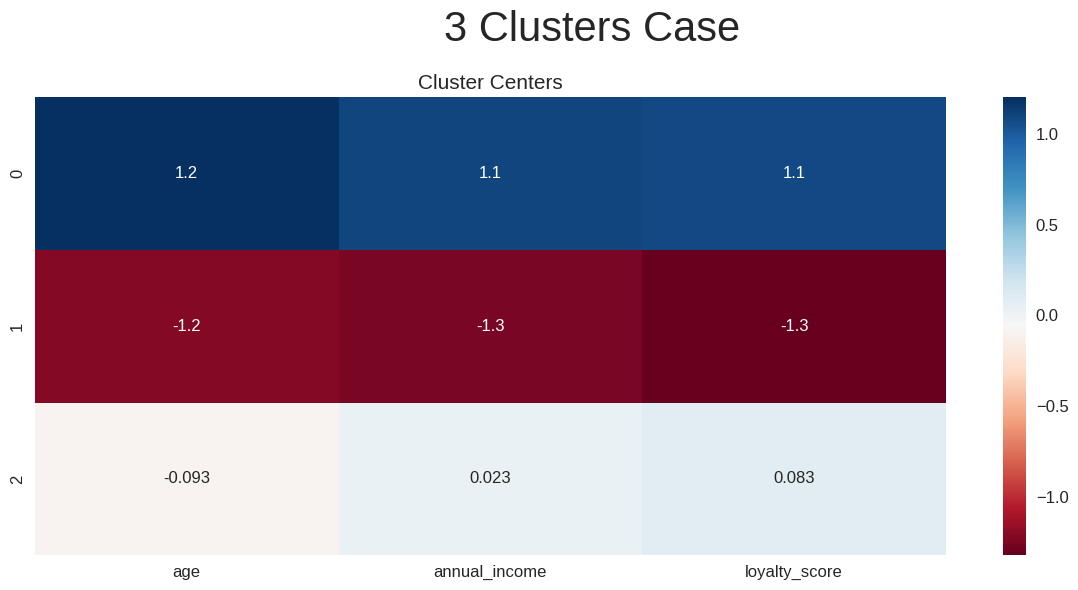

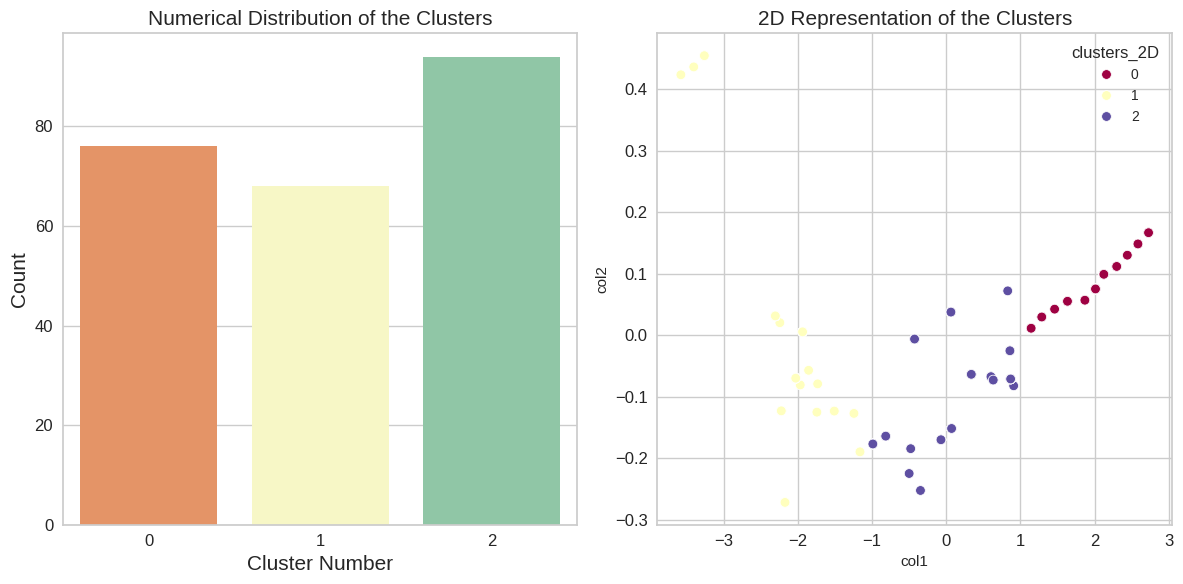

In [ ]:
features = ['age', 'annual_income', 'loyalty_score']
X = data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Determine the optimal number of cluste
plot_clusters(3,data,features)

Các cụm(clusters) này được miêu tả như sau:

*   Cụm 0: xấp xỉ 1.1-1.2, cụm cho thấy xu hướng những người lớn tuổi có thu nhập cao và điểm khách hàng lớn hơn so với mức trung bình
*   Cụm 1: xấp xỉ -1.3, điều này đại diện cho nhóm khách hàng trẻ tuổi (<30) có thu nhập và điểm khách hàng thấp hơn so với mức trung bình
*   Cụm 2: xấp xỉ -0.093, cụm đại diện cho những khách hàng trung niên khoảng 30-40 tuổi, có mức thu nhập và điểm khách hàng gần với mức trung bình nhất





###Trường hợp 5 cụm:


Cluster Counts:
    clusters_2D  count
3            3     69
0            0     60
2            2     50
1            1     43
4            4     16


<Figure size 1200x600 with 0 Axes>

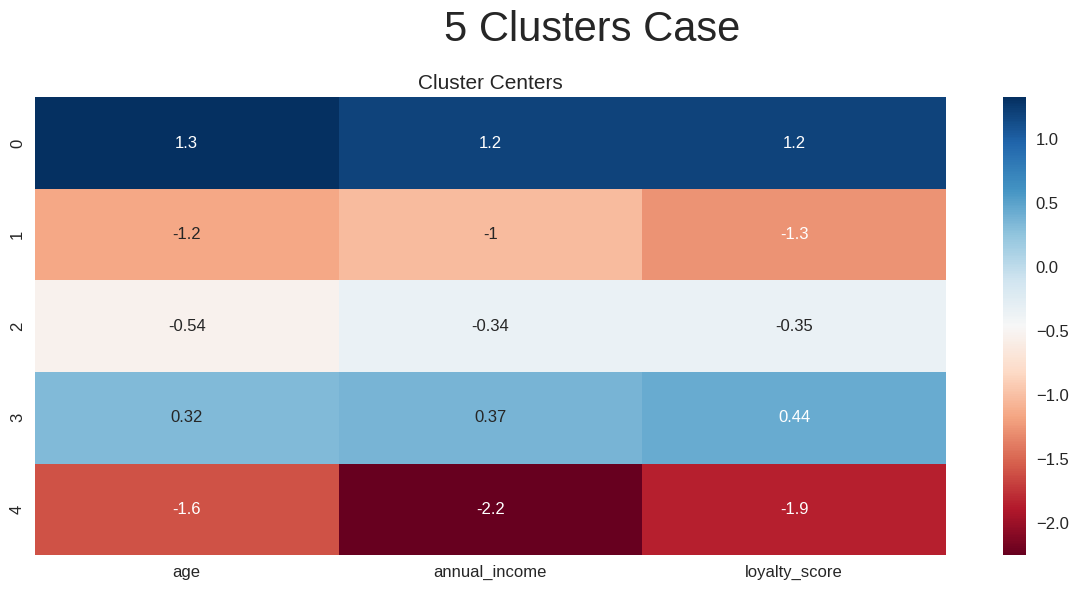

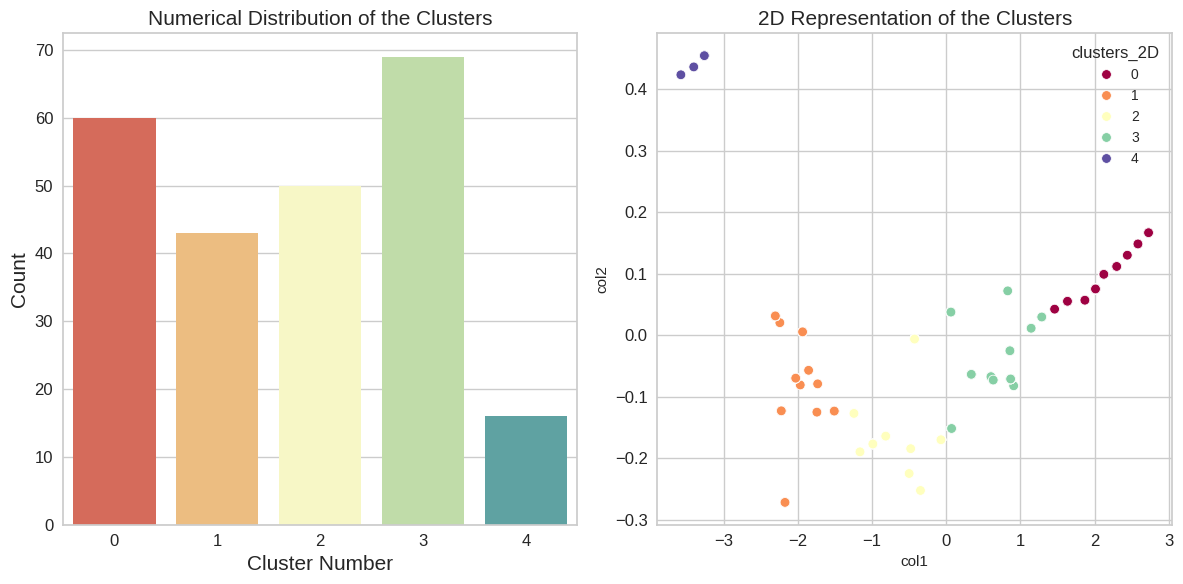

In [ ]:
plot_clusters(5,data,features)

5 cụm này có thể được phân tích như sau:

*   Cụm 0: Mức khách hàng lớn tuổi (47-55) có mức thu nhập và điểm thành viên cao hơn rất nhiều so với trung bình
*   Cụm 1: Mức khách hàng có độ tuổi từ 25-30 có mức thu nhập thấp và điểm khách hàng rất thấp
*   Cụm 2: Mức khách hàng có độ tuổi 31-37 có mức thu nhập và điểm thành viên tương đối thấp hơn so với trung bình
*   Cụm 3: Mức khách hàng có độ tuổi 38-46 với mức thu nhập và điểm thành viên cao hơn so với mức trung bình
*   Cụm 4: Mức khách hàng trẻ tuổi 22-24 với mức thu nhập và điểm thành viên thấp nhất



###Trường hợp 6 cụm:

Cluster Counts:
    clusters_2D  count
2            2     59
4            4     46
0            0     43
3            3     39
1            1     35
5            5     16


<Figure size 1200x600 with 0 Axes>

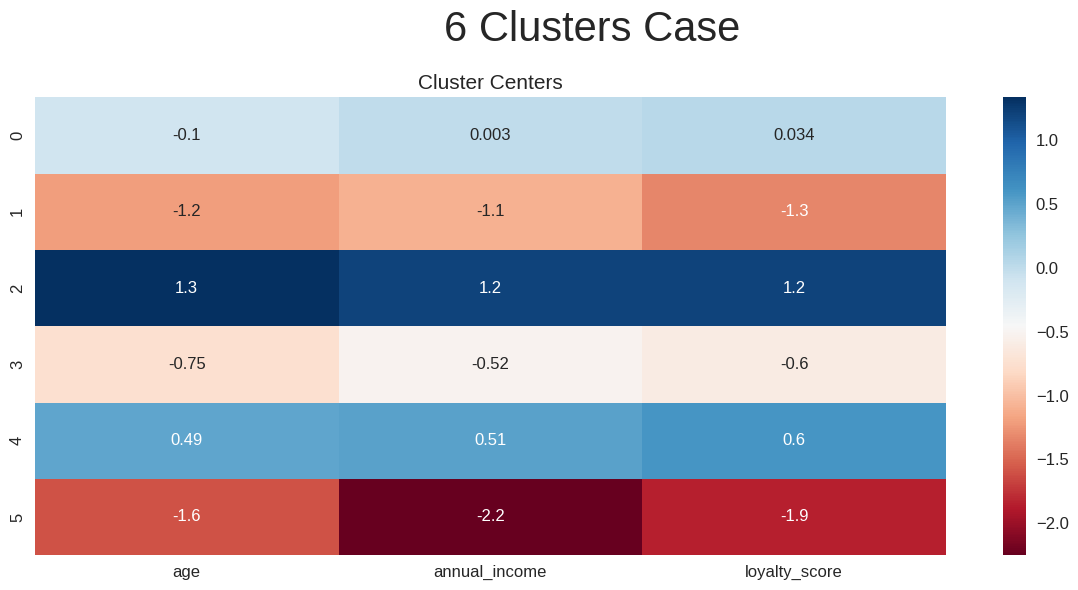

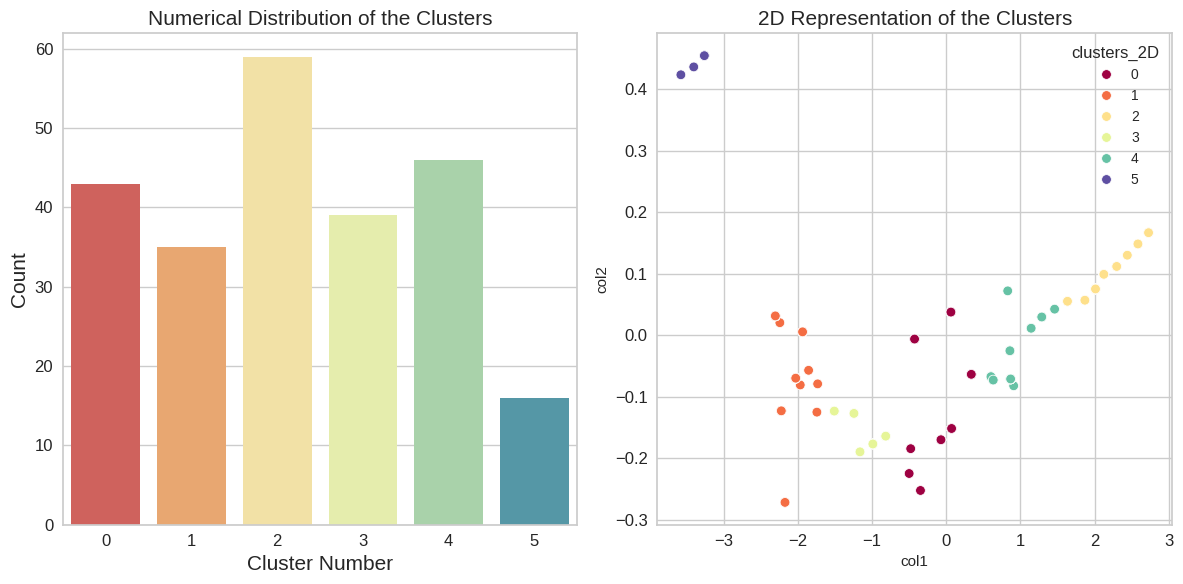

In [ ]:
plot_clusters(6,data,features)

Phân tích 6 cụm:
*   Cụm 0: Khách hàng từ 34-40 tuổi,thu nhập và điểm khách hàng ở mức trung bình.
*   Cụm 1: Khách hàng từ 25-29 tuổi, mức thu nhập thấp, điểm thành viên thấp
*   Cụm 2: Cụm khách hàng lớn tuổi nhất, thu nhập cao, điểm khách hàng cao nhất.
*   Cụm 3: Khoảng tuổi 30-33, thu nhập thấp hơn và ít trung thành hơn nhóm 0, nhưng không bằng nhóm 1.
*   Cụm 4: Khoảng tuổi từ 41-47,có thu nhập và điểm thành viên tốt hơn trung bình, nhưng không bằng nhóm 2
*   Cụm 5: Nhóm khách hàng trẻ tuổi nhất, có thu nhập và điểm thành viên rất thấp.




#Hyerachical Clustering

Mình sẽ bắt đầu tạo biểu đồ Dendrogram sử dụng 3 cột dữ liệu đã được chuẩn hóa:

In [ ]:
data.head()

,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency,cluster,cluster_silhouette,cluster_db,3_clusters_2D,5_clusters_2D,6_clusters_2D
0,1,25,45000,200,4.5,North,12,1,2,3,1,1,1
1,2,34,55000,350,7.0,South,18,0,5,4,2,2,0
2,3,45,65000,500,8.0,West,22,2,1,0,0,3,4
3,4,22,30000,150,3.0,East,10,1,4,1,1,4,5
4,5,29,47000,220,4.8,North,13,1,2,3,1,1,1


In [ ]:
encoder = LabelEncoder()

data2['region'] = encoder.fit_transform(data2['region'])


In [ ]:
data2_sc = data2.drop(['region'],axis=1)

scaler = StandardScaler()

scaled_columns = data2_sc.columns

data2_sc[scaled_columns] = scaler.fit_transform(data2_sc[scaled_columns])

data2_sc.head()

,age,annual_income,purchase_amount,loyalty_score,purchase_frequency
0,-1.465632,-1.090306,-1.614441,-1.210582,-1.712679
1,-0.501151,-0.211563,-0.541153,0.108642,-0.394950
2,0.677658,0.667180,0.532134,0.636332,0.483536
3,-1.787125,-2.408420,-1.972203,-2.002117,-2.151922
4,-1.036974,-0.914557,-1.471336,-1.052275,-1.493057


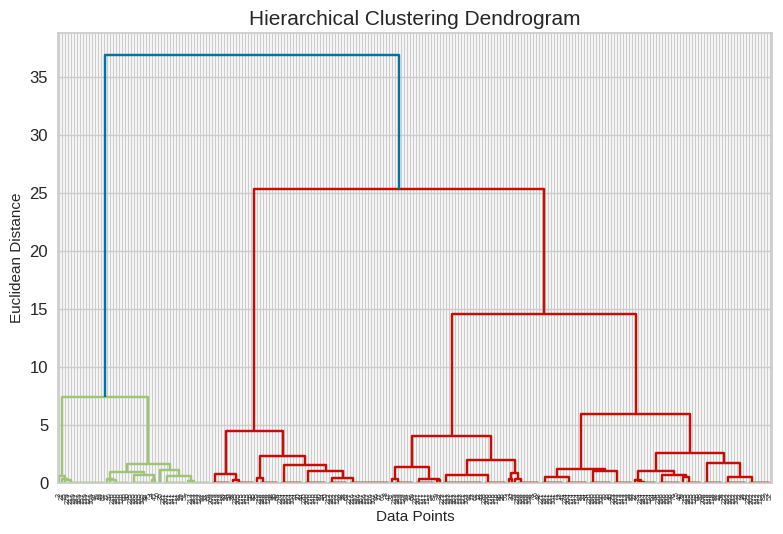

In [ ]:
data3_sc = data2_sc[['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'purchase_frequency']]

# Continue with the rest of your code
linkage_matrix = linkage(data2_sc, method='ward')
dendrogram_info = dendrogram(linkage_matrix)

plt.title("Hierarchical Clustering Dendrogram", size=15)
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")

plt.tight_layout()

Theo biểu đồ ở trên, số cụm nên chia từ 2-4 cụm

Mình sẽ vẽ lại cùng một dendrogram bằng cách đặt ngưỡng tại khoảng cách Euclidean là 10; kết quả là sẽ có 4 màu khác nhau (và 4 cụm)."

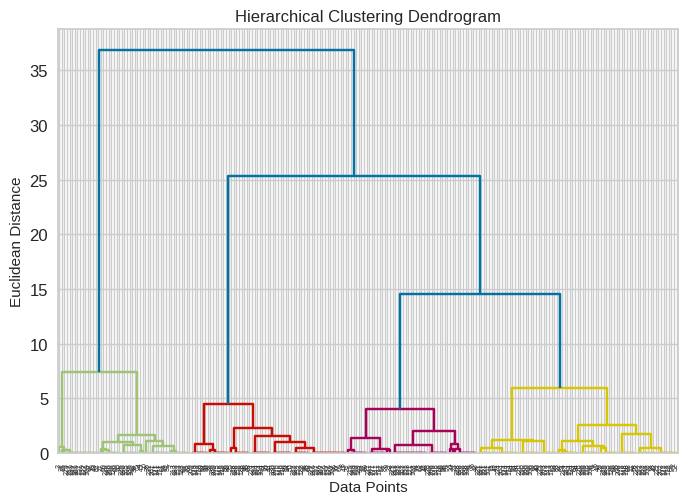

In [ ]:
# Visually identify the ”best” number of clusters and adjust the color_threshold
linkage_matrix = linkage(data2_sc,method='ward')
dendrogram_info = dendrogram(linkage_matrix,color_threshold=10)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance");

##Trường hợp k=4:

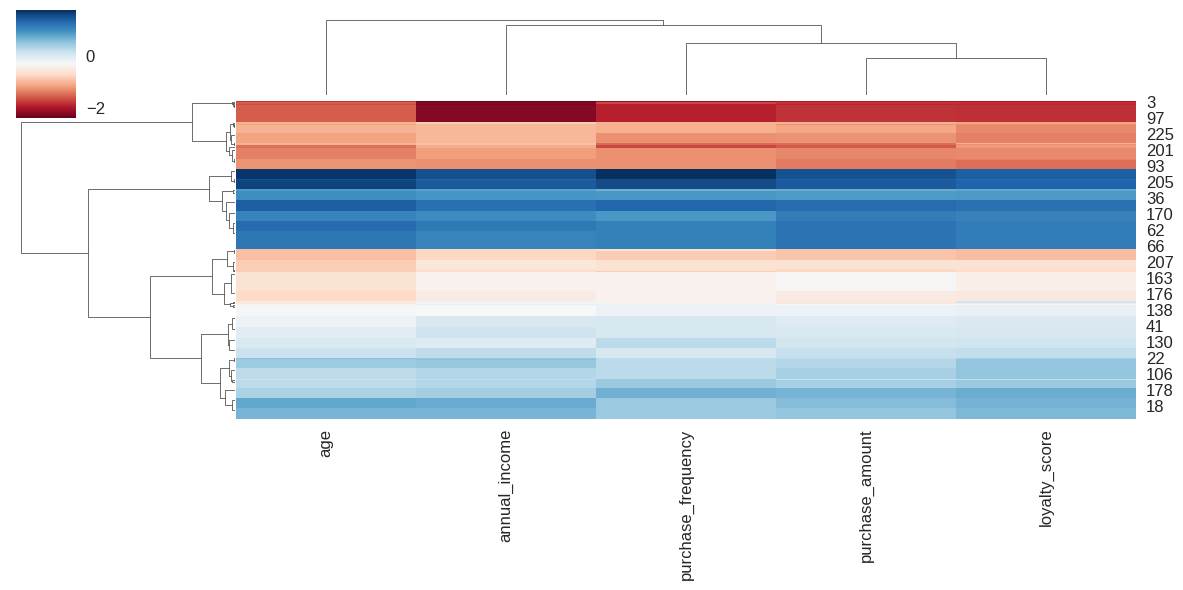

In [ ]:
# create a cluster map
clustermap = sns.clustermap(data3_sc,method='ward',cmap='RdBu',figsize=(12,6),xticklabels=data3_sc.columns)
plt.show()

In [ ]:
agg_4Cl = AgglomerativeClustering(4)
agg_4Cl.fit(data3_sc)

print(Counter(agg_4Cl.labels_))

silhouette_score(data3_sc,agg_4Cl.labels_)

Counter({1: 77, 2: 60, 0: 51, 3: 50})


0.6008880851707614

##Trường hợp k=5:

In [ ]:
# hierarchical clustering with sklearn, with 5 clusters
agg = AgglomerativeClustering(5)
agg.fit(data3_sc)

print(Counter(agg.labels_))

Counter({0: 77, 2: 60, 1: 50, 3: 35, 4: 16})


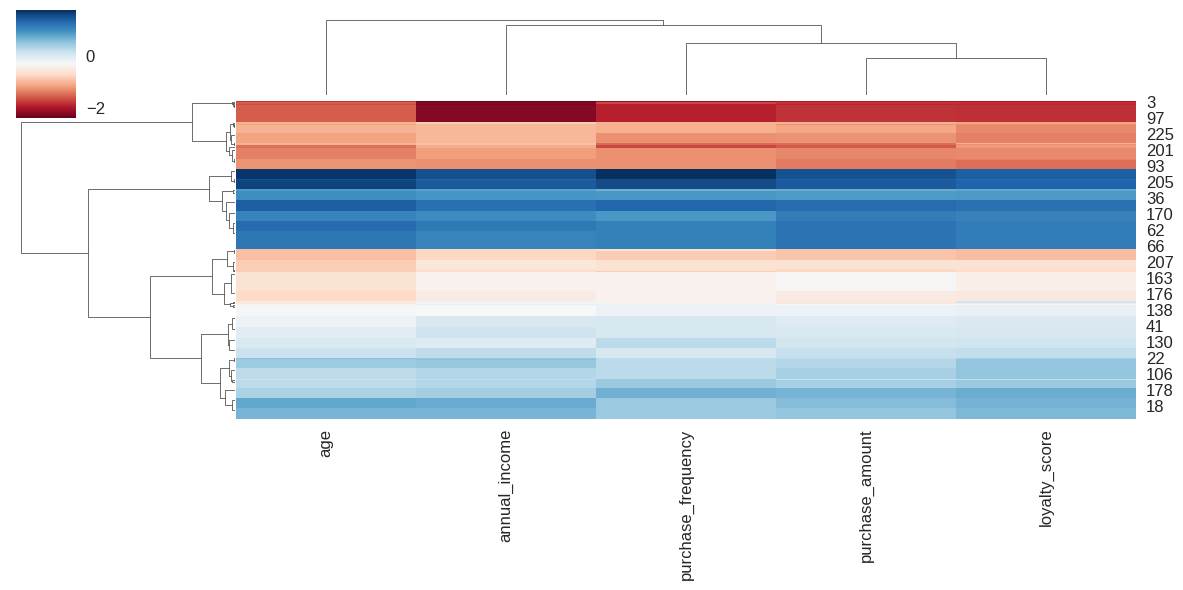

In [ ]:
# create a cluster map
clustermap = sns.clustermap(data3_sc,method='ward',cmap='RdBu',figsize=(12,6),xticklabels=data3_sc.columns)
plt.show()

In [ ]:
agg_5Cl = AgglomerativeClustering(5)
agg_5Cl.fit(data3_sc)

print(Counter(agg_5Cl.labels_))

silhouette_score(data3_sc,agg_5Cl.labels_)

Counter({0: 77, 2: 60, 1: 50, 3: 35, 4: 16})


0.6366205172720858

##Trường hợp k=6

In [ ]:
# hierarchical clustering with sklearn, with 6 clusters
agg = AgglomerativeClustering(6)
agg.fit(data3_sc)

print(Counter(agg.labels_))

Counter({0: 60, 1: 50, 2: 46, 3: 35, 5: 31, 4: 16})


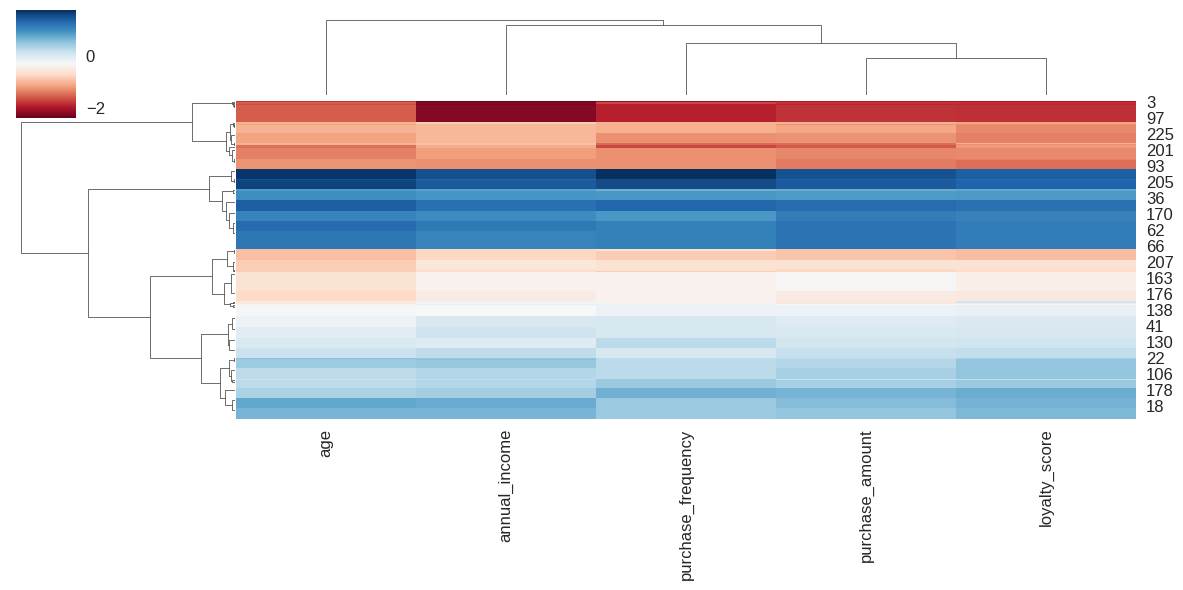

In [ ]:
# create a cluster map
clustermap = sns.clustermap(data3_sc,method='ward',cmap='RdBu',figsize=(12,6),xticklabels=data3_sc.columns)
plt.show()

In [ ]:
agg_6Cl = AgglomerativeClustering(6)
agg_6Cl.fit(data3_sc)

print(Counter(agg_6Cl.labels_))

silhouette_score(data3_sc,agg_6Cl.labels_)

Counter({0: 60, 1: 50, 2: 46, 3: 35, 5: 31, 4: 16})


0.6136067075771965

Theo như cách tính Silhouette scores thì k=5 trong Hyerachical model sẽ cho kết quả 0.6366205172720858 là kết quả tốt nhất


#Customer Personas
Mình sẽ phân tích và tạo hồ sơ khách hàng với k = 5 bằng các dữ liệu tìm được:

#KMeans Model Prediction

In [ ]:
ID_201 = pd.DataFrame({'user_id':[201],'age':39,'annual_income':35,'purchase_amount':320,'purchase_frequency':11,'loyalty_score':45})
ID_202 = pd.DataFrame({'user_id':[202],'age':29,'annual_income':55,'purchase_amount':170,'purchase_frequency':17,'loyalty_score':65})

ID_201.head()


,user_id,age,annual_income,purchase_amount,purchase_frequency,loyalty_score
0,201,39,35,320,11,45


In [ ]:
ID_202.head()


,user_id,age,annual_income,purchase_amount,purchase_frequency,loyalty_score
0,202,29,55,170,17,65


Mình sẽ tạo DataFrame mới:

In [ ]:
data2_sc = data2.drop(['region'], axis=1)

scaler = StandardScaler()

# Fit the scaler to only the columns you want to scale
numerical_cols = ['age', 'annual_income', 'loyalty_score']
scaler.fit(data2_sc[numerical_cols])

# Tạo 2 DataFrame mới với đầy đủ các cột
ID_201 = pd.DataFrame({'user_id': [201], 'age': 22, 'annual_income': 36000,'purchase_amount':220,'purchase_frequency':12, 'loyalty_score': 13})
ID_202 = pd.DataFrame({'user_id': [202], 'age': 48, 'annual_income': 55000,'purchase_amount':170,'purchase_frequency':17, 'loyalty_score': 87})

#Scale data:
data2_sc[numerical_cols] = scaler.transform(data2_sc[numerical_cols]) # Scale data2_sc

# scale ID_201 và ID_202
ID_201[numerical_cols] = scaler.transform(ID_201[numerical_cols])
ID_202[numerical_cols] = scaler.transform(ID_202[numerical_cols])

Text(0.5, 1.0, 'Cluster Centers')

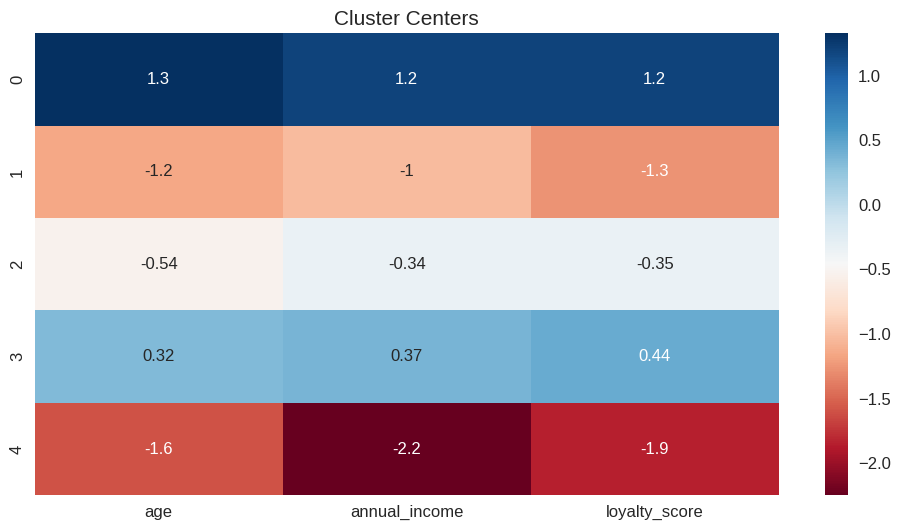

In [ ]:
# Initiating KMeans. n_clusters = 5
km5 = KMeans(n_clusters=5, n_init=10, random_state=42)
# Fit the model using only the numerical_cols
km5.fit(data2_sc[numerical_cols])  # Fit using the desired columns
# Now you can predict on ID_201 and ID_202
# Fit model and predict clusters
yhat = km5.fit_predict(data2_sc[numerical_cols])  # Predict using the desired columns
data2_sc[f"{k}_clusters_2D"] = yhat  # Assuming k is defined elsewhere
five_cluster_data = pd.DataFrame(km5.cluster_centers_, columns=numerical_cols)

# As a remainder, plot the a heatmap of the cluster centers
five_cluster_data = pd.DataFrame(km5.cluster_centers_, columns=numerical_cols)

ax = plt.figure(figsize=(12, 6))
ax = sns.heatmap(data=five_cluster_data,cmap='RdBu',annot=True)
ax.set_title('Cluster Centers',fontsize=15)


In [ ]:
km5.predict(ID_201[numerical_cols])

array([2], dtype=int32)

Theo mô hình KMeans Prediction đã được trained, với khách hàng ID_201 ví dụ ta thấy được khách hàng thuộc cụm 2, mức khách hàng có độ tuổi, thu nhập và điểm khách hàng ở mức trung bình.

In [ ]:
km5.predict(ID_202[numerical_cols])

array([0], dtype=int32)

Theo mô hình KMeans Prediction đã được trained, với khách hàng ID_202 ví dụ ta thấy được khách hàng thuộc cụm 0.(Khách hàng có độ tuổi, thu nhập và điểm khách hàng cao hơn mức trung bình nhiều).